In [24]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
import seaborn as sns
import pandas as pd
%matplotlib inline

In [10]:
file = uproot.open(
    "tracking_losses_ntuple_B_EndVeloP.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[
    (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)
]  # B: 9056
lost = allcolumns[
    (allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)
]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

41978 8523
50501


In [11]:
rad_length_found = ak.to_numpy(found["rad_length_frac"])
eta_found = ak.to_numpy(found["eta"])
phi_found = ak.to_numpy(found["phi"])
rad_length_lost = ak.to_numpy(lost["rad_length_frac"])
eta_lost = ak.to_numpy(lost["eta"])
phi_lost = ak.to_numpy(lost["phi"])

stretch_factor = ak.num(eta_lost, axis=0) / ak.num(eta_found, axis=0)
print("stretch factor: ", stretch_factor)

stretch factor:  0.20303492305493354


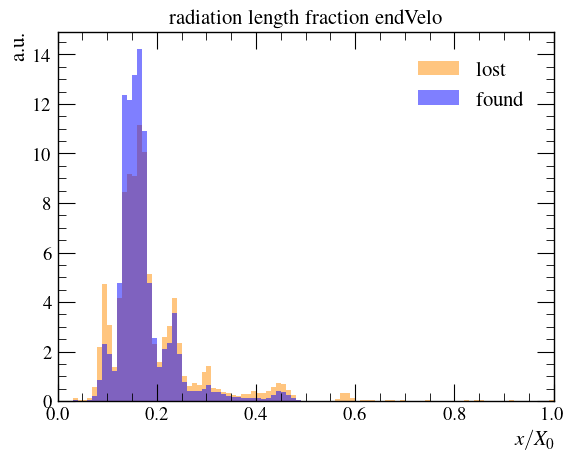

In [12]:
plt.hist(
    rad_length_lost,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="lost",
    range=[0, 1],
)
plt.hist(
    rad_length_found,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="found",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction endVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

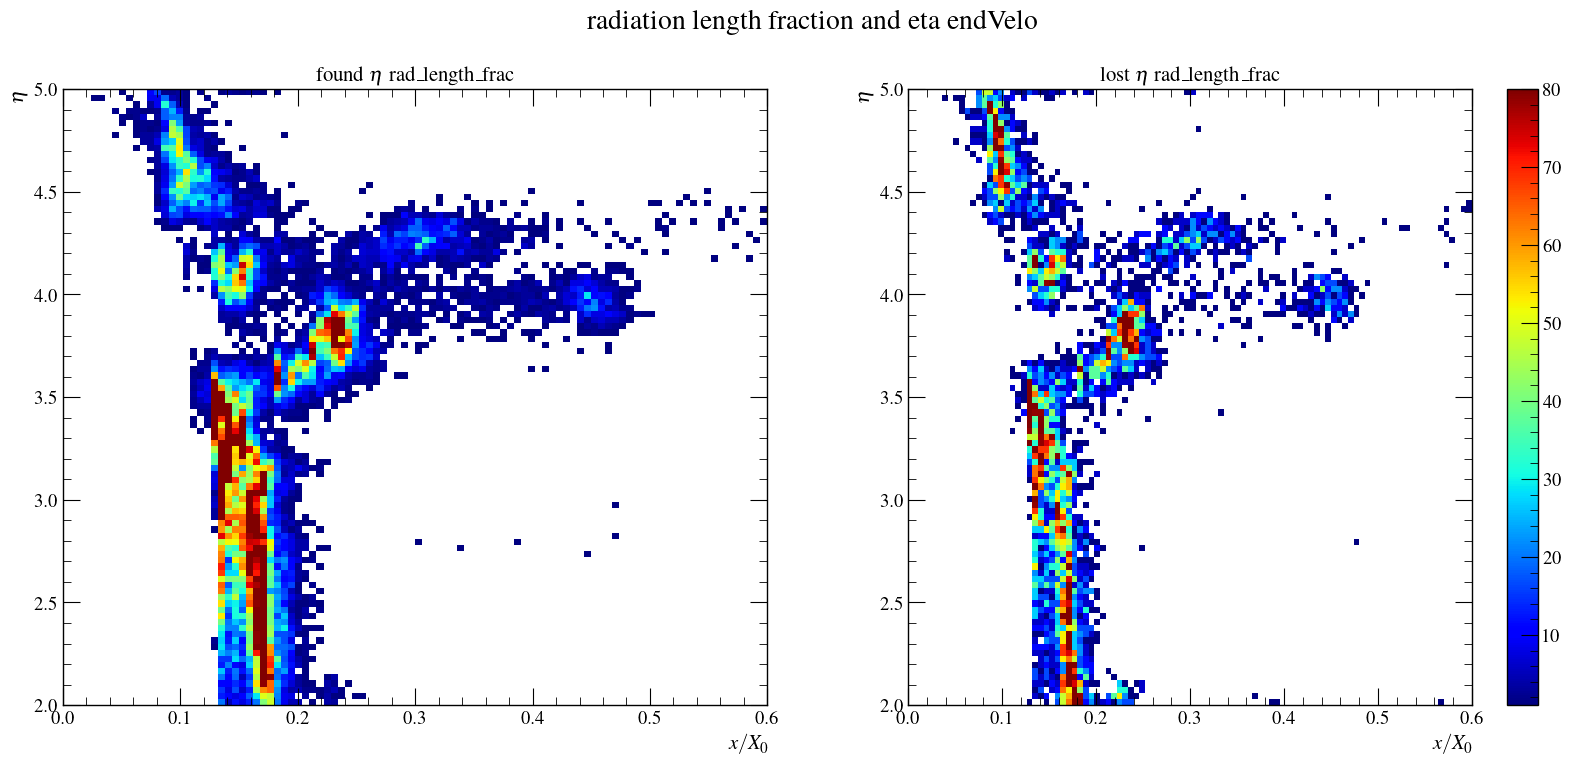

In [13]:
nbins = 100
vmax = 80

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    rad_length_found,
    eta_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.6], [2, 5]],
)
ax0.set_xlabel(f"$x/X_0$")
ax0.set_ylabel(f"$\eta$")
ax0.set_title(f"found $\eta$ rad_length_frac")

a1 = ax1.hist2d(
    rad_length_lost,
    eta_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[0, 0.6], [2, 5]],
)
ax1.set_xlabel(f"$x/X_0$")
ax1.set_ylabel(f"$\eta$")
ax1.set_title(f"lost $\eta$ rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.suptitle("radiation length fraction and eta endVelo")
plt.colorbar(a0[3], ax=ax1)

plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.19830920321074946, 'x': -4.49175976974402e-05, 'y': 0.00039490060416272056, 'tx': 0.00015102371088508598, 'ty': -0.3004315695136339, 'qop': -15.314945266490128, 'x^2': -1.8619394568578818e-05, 'x y': -4.953907513838906e-06, 'x tx': 0.021617503882699386, 'x ty': 0.03829244150062255, 'x qop': -0.41798007270055415, 'y^2': -2.4410328131494868e-05, 'y tx': -0.03443063985633742, 'y ty': 0.024201355785359608, 'y qop': 0.069823295273139, 'tx^2': -9.507076220830514, 'tx ty': -0.3980701633198789, 'tx qop': -0.04742639222342226, 'ty^2': -5.342167619183405, 'ty qop': 0.04842038611881145, 'qop^2': 0.2070268831284635, 'x^3': 1.5823479402461545e-07, 'x^2 y': -5.806838940825474e-07, 'x^2 tx': -0.00023418353598118923, 'x^2 ty': 0.0037081774556846224, 'x^2 qop': 0.01641641113222204, 'x y^2': 6.398758958085149e-08, 'x y tx': -0.002932641224303519, 'x y ty': -0.001396824762733282, 'x y qop': -0.020888196868450136, 'x tx^2': 0.0909690812412

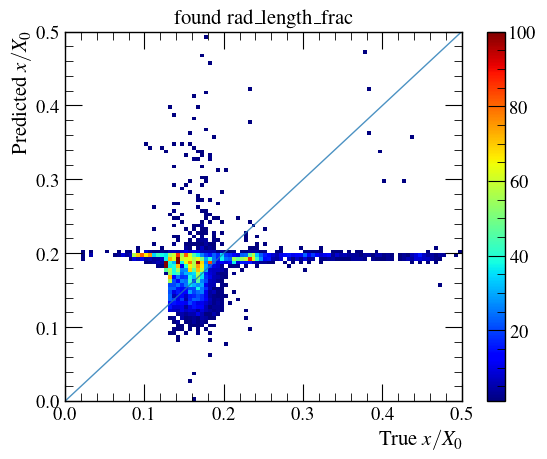

In [14]:
rad_length_frac = found["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = found["ideal_state_770_tx"]
    slopey = found["ideal_state_770_ty"]
    x = found["ideal_state_770_x"]
    y = found["ideal_state_770_y"]
    qop = found["ideal_state_770_qop"]
elif state == 2:
    slopex = found["ideal_state_9410_tx"]
    slopey = found["ideal_state_9410_ty"]
    x = found["ideal_state_9410_x"]
    y = found["ideal_state_9410_y"]
    qop = found["ideal_state_9410_qop"]

data = ak.zip({
    "rad_length_frac": rad_length_frac,
    "x": x,
    "y": y,
    "tx": slopex,
    "ty": slopey,
    "qop": qop,
})
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    5,
    include_bias=True,
)

nbins = 100
vmax = 100

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.5], [0, 0.5]],
)
plt.plot([0, 0.5], [0, 0.5], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"found rad_length_frac")

plt.colorbar(a0[3])
plt.show()

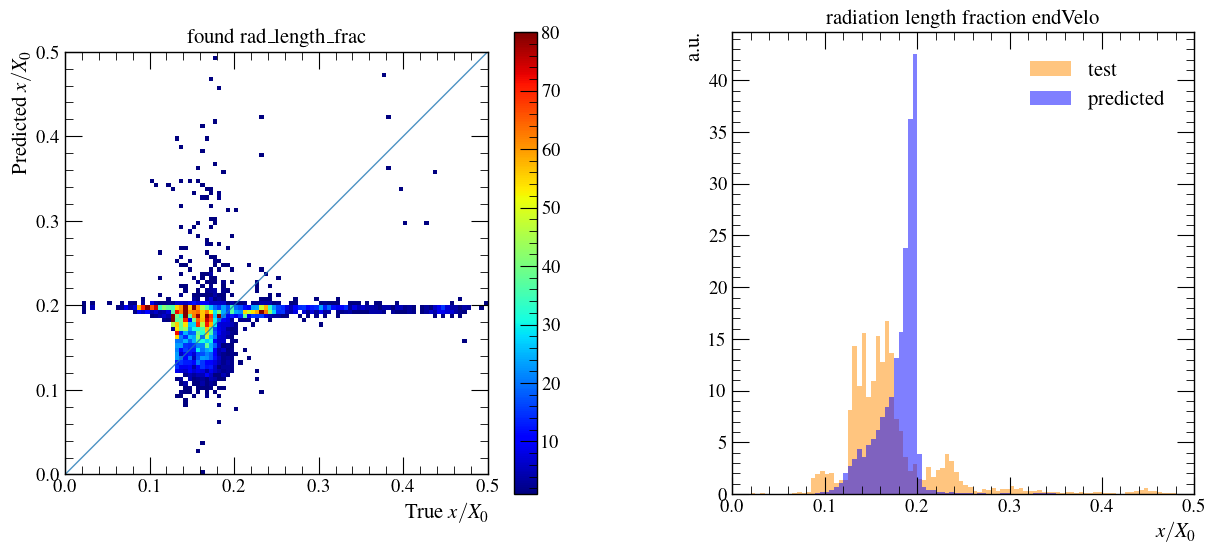

In [15]:
nbins = 100
vmax = 80

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# ax0.set_aspect("equal")

a0 = ax0.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.5], [0, 0.5]],
)
ax0.plot([0, 0.5], [0, 0.5], marker="", alpha=0.8)
ax0.set_box_aspect(1)
ax0.set_xlabel(f"True $x/X_0$")
ax0.set_ylabel(f"Predicted $x/X_0$")
ax0.set_title(f"found rad_length_frac")
plt.colorbar(a0[3], ax=ax0)

ax1.hist(
    xx0_test,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="test",
    range=[0, 0.5],
)
ax1.hist(
    xx0_predicted,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="predicted",
    range=[0, 0.5],
)
ax1.set_xlim(0, 0.5)
ax1.set_title("radiation length fraction endVelo")
ax1.set_xlabel(f"$x/X_0$")
ax1.set_ylabel("a.u.")
ax1.set_box_aspect(1)

ax1.legend()

# plt.gca().set_aspect("equal")
plt.show()

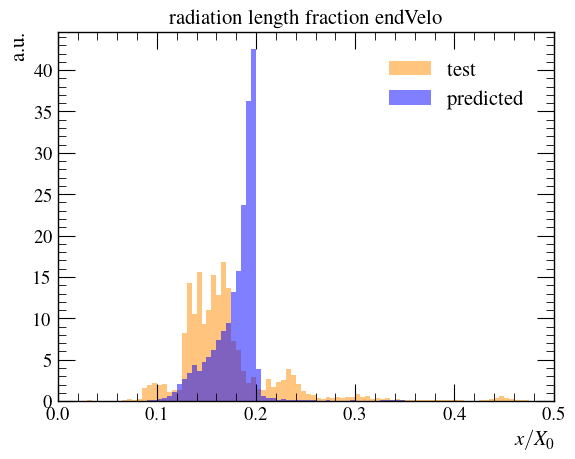

In [16]:
plt.hist(
    xx0_test,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="test",
    range=[0, 0.5],
)
plt.hist(
    xx0_predicted,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="predicted",
    range=[0, 0.5],
)
plt.xlim(0, 0.5)
# plt.yscale("log")
plt.title("radiation length fraction endVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.2484410418213911, 'x': -0.0007601095488043627, 'y': 0.0010569724392146917, 'tx': 0.6185505303064777, 'ty': -0.9394058560136732, 'qop': -9.741031889614183, 'x^2': -0.00016580416280366622, 'x y': 5.149038989659081e-05, 'x tx': 0.22996768886351043, 'x ty': -0.043161009059129354, 'x qop': -0.21658279194428842, 'y^2': 3.9826067539320166e-05, 'y tx': -0.033498957247677735, 'y ty': -0.08085122767618998, 'y qop': 0.06428923004582791, 'tx^2': -83.06687438225835, 'tx ty': 28.76266798578089, 'tx qop': -0.32072666519746007, 'ty^2': 32.80290436519906, 'ty qop': 0.29785759094660047, 'qop^2': 0.7177557091128425, 'x^3': -1.037888276319177e-06, 'x^2 y': 5.744977724613286e-07, 'x^2 tx': 0.0016261562680787358, 'x^2 ty': 0.00819223051446815, 'x^2 qop': 0.014940216048602184, 'x y^2': 1.55836456652794e-06, 'x y tx': -0.009042353485603404, 'x y ty': 0.002769481233443616, 'x y qop': 0.007035099510620806, 'x tx^2': -0.623629094925692, 'x tx ty'

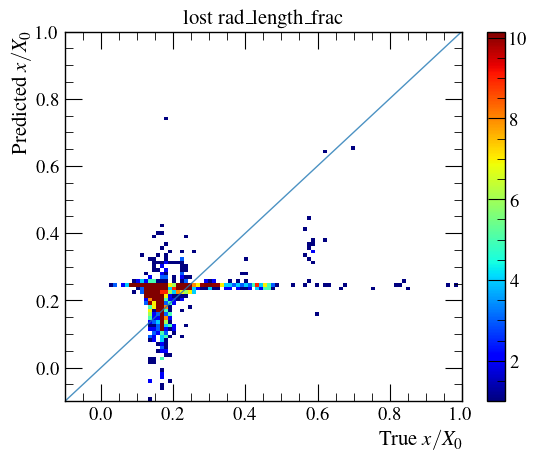

In [17]:
rad_length_frac = lost["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = lost["ideal_state_770_tx"]
    slopey = lost["ideal_state_770_ty"]
    x = lost["ideal_state_770_x"]
    y = lost["ideal_state_770_y"]
    qop = lost["ideal_state_770_qop"]
elif state == 2:
    slopex = lost["ideal_state_9410_tx"]
    slopey = lost["ideal_state_9410_ty"]
    x = lost["ideal_state_9410_x"]
    y = lost["ideal_state_9410_y"]
    qop = lost["ideal_state_9410_qop"]

data = ak.zip(
    {
        "rad_length_frac": rad_length_frac,
        "x": x,
        "y": y,
        "tx": slopex,
        "ty": slopey,
        "qop": qop,
    }
)
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    5,
    include_bias=True,
)

nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[-0.1, 1.0], [-0.1, 1.0]],
)
plt.plot([-0.1, 1.0], [-0.1, 1.0], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"lost rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()

In [25]:
df = pd.DataFrame({
    "phi": phi_found,
    "eta": eta_found,
    "rad_length_frac": rad_length_found
})

In [27]:
fig, ax = plt.subplots(figsize=(9, 6))

contour = sns.kdeplot(
    data=df,
    x="phi",
    y="eta",
    cmap="Greens",
    fill=True,
    cbar=True,
    # cbar_kws={"label": "density of two variables (KDE weights)", "format": "{x:.1e}"},
)

ax.set_title(f"Radiation Length Fraction $x/X_0$", size=14)
ax.set_xlabel(f"$\phi$ [°]", size=10)
ax.set_ylabel(f"$\eta$", size=10)

plt.show()

RuntimeError: latex was not able to process the following string:
b'sale price $'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpg0jlxahb 82002a6a534310632a0ec6d082310260.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./82002a6a534310632a0ec6d082310260.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-09-24>
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/base/article
.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class

(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/base/size10.
clo))
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/mathp
tmx.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/type1cm/type
1cm.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/cm-super/typ
e1ec.sty
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/base/t1cmr.f
d))
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/base/inputen
c.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/geometry/geo
metry.sty
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/graphics/key
val.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/generic/iftex/ifvt
ex.sty
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/generic/iftex/ifte
x.sty)))
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/underscore/u
nderscore.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/base/textcom
p.sty)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/l3backend/l3
backend-dvips.def)
No file 82002a6a534310632a0ec6d082310260.aux.

(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/ot1pt
m.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/ot1zt
mcm.fd)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/omlzt
mcm.fd)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/omszt
mcm.fd)
(/cvmfs/sft.cern.ch/lcg/external/texlive/2020/texmf-dist/tex/latex/psnfss/omxzt
mcm.fd)
! Extra }, or forgotten $.
<recently read> }
                 
l.30 {\rmfamily sale price $}
                             %
No pages of output.
Transcript written on tmpg0jlxahb/82002a6a534310632a0ec6d082310260.log.




<Figure size 900x600 with 2 Axes>